# Stabilization of nonlinear systems

**Adapted from**: Examples 1, 2 and 3 of [PPA04]

[PPA04] Prajna, Stephen, Pablo A. Parrilo, and Anders Rantzer.
*Nonlinear control synthesis by convex optimization*.
IEEE Transactions on Automatic Control 49.2 (2004): 310-314.

In [1]:
using DynamicPolynomials
@polyvar x[1:2]

using SumOfSquares
using CSDP
using LinearAlgebra # for ⋅
using MultivariatePolynomials
divergence(f) = sum(differentiate.(f, x))
function controller(f, g, b, α, degs)
    solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
    model = SOSModel(solver)
    a = 1
    monos = monomials(x, degs)
    N = length(monos) + 1
    @variable(model, c[1:N] in MOI.NormOneCone(N))
    c_poly = polynomial(c[2:end], monos)
    fagc = f * a + g * c_poly
    @constraint(model, b * divergence(fagc) - α * differentiate(b, x) ⋅ fagc in SOSCone())
    @objective(model, Min, c[1])
    optimize!(model)
    if termination_status(model) != MOI.OPTIMAL
        @warn("Termination status $(termination_status(model)): $(raw_status(model))")
    end
    u = value(c_poly) / value(a)
    return MultivariatePolynomials.mapcoefficientsnz(coef -> abs(coef) < 1e-6 ? 0.0 : coef, u)
end

import DifferentialEquations, Plots
function phase_plot(f, quiver_scaling, Δt, X0, solver = DifferentialEquations.Tsit5())
    ∇(vx, vy) = [fi(x[1] => vx, x[2] => vy) for fi in f]
    ∇pt(v, p, t) = ∇(v[1], v[2])
    function traj(v0)
        tspan = (0.0, Δt)
        prob = DifferentialEquations.ODEProblem(∇pt, v0, tspan)
        return DifferentialEquations.solve(prob, solver, reltol=1e-8, abstol=1e-8)
    end
    ticks = -5:0.5:5
    X = repeat(ticks, 1, length(ticks))
    Y = X'
    Plots.quiver(X, Y, quiver = (x, y) -> ∇(x, y) / quiver_scaling, linewidth=0.5)
    for x0 in X0
        Plots.plot!(traj(x0), vars=(1, 2), label = nothing)
    end
    Plots.plot!(xlims = (-5, 5), ylims = (-5, 5))
end

phase_plot (generic function with 2 methods)

## Example 1

In [2]:
g = [0, 1]
f = [x[2] - x[1]^3 + x[1]^2, 0]
b = 3x[1]^2 + 2x[1]*x[2] + 2x[2]^2
u = controller(f, g, b, 4, 0:3)

-0.1293034007254552x₂³ - 1.2298305283568234x₁ - 0.5738994624781782x₂

We find the controller above which gives the following phase plot.

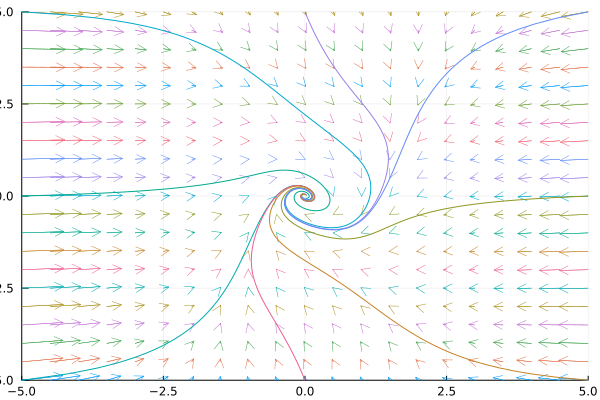

In [3]:
phase_plot(f + g * u, 200, 10.0, [[x1, x2] for x1 in -5:5:5, x2 in -5:5:5 if x1 != 0 || x2 != 0])

## Example 2

In [4]:
g = [0, 1]
f = [2x[1]^3 + x[1]^2*x[2] - 6x[1]*x[2]^2 + 5x[2]^3, 0]
b = x[1]^2 + x[2]^2
u = controller(f, g, b, 2.5, 0:3)

-3.138762080285357x₁³ + 4.004075875205108x₁²x₂ - 6.465434739454952x₁x₂² - 3.470949019517451x₂³

We find the controller above which gives the following phase plot.

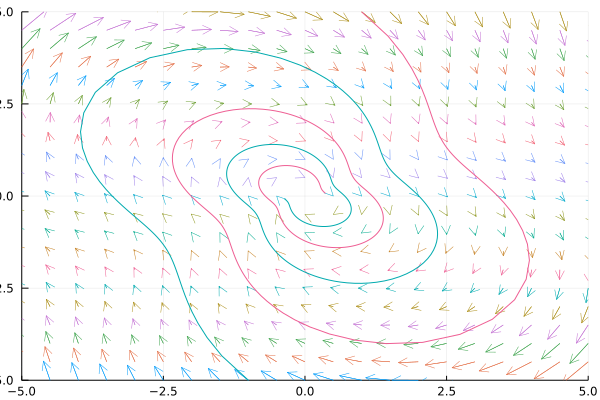

In [5]:
phase_plot(f + g * u, 2000, 5.0, [[-1.0, -5.0], [1.0, 5.0]])

## Example 3

In [6]:
g = [0, x[2]]
f = [-6x[1]*x[2]^2 - x[1]^2*x[2] + 2x[2]^3, 0]
b = x[1]^2 + x[2]^2
u = controller(f, g, b, 3, 0:2)

0.1805959449353567x₁² - 2.7374334415573736x₂²

We find the controller above which gives the following phase plot.

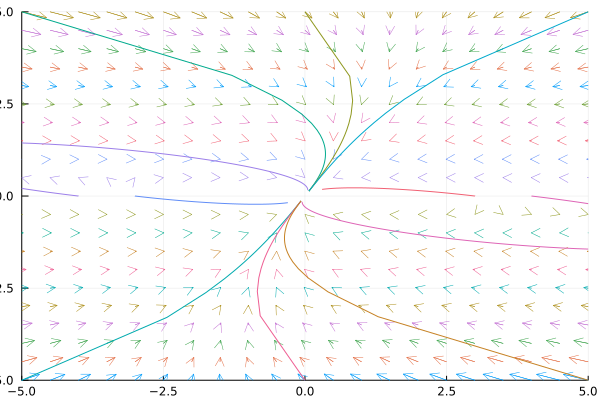

In [7]:
X0 = [Float64[x1, x2] for x1 in -5:5:5, x2 in -5:5:5 if x2 != 0]
ε = 1e-4 # We separate the starting point slightly from the hyperplane `x2 = 0` which is invariant.
push!(X0, [-4,  ε])
push!(X0, [-3, -ε])
push!(X0, [ 3,  ε])
push!(X0, [ 4, -ε])
phase_plot(f + g * u, 2000, 10.0, X0)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*